In [1]:
!pip install bert-serving-server
!pip install graphviz
!pip install pydot
!pip install bert-serving-client
!pip install fasttext
!pip install mlflow

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [ ]:
!bert-serving-start -model_dir ./wwm_cased_L-24_H-1024_A-16/ -num_worker 1 -pooling_strategy NONE

In [6]:
"""Model layers"""
max_sequence_length = 25
max_char_length = 20

dropout_rate = 0.5
recurrent_dropout_rate = 0.5
lstm_size = 256
dense_size_word = 256
dense_size_case = 10
optimizer = "nadam"

batch_size=32
epochs=64
validation_split=0.1

# Preprocessing

In [7]:
import numpy as np
import time

In [8]:
# dictionary of all possible characters
char2idx = {"PADDING": 0, "UNKNOWN": 1}
for c in " 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZé.,-_()[]{}!?:;#'\"/\\%$`&=*+@^~|<>ěščřžýáíéůúĚŠČŘŽÝÁÍÉŮÚ":
    char2idx[c] = len(char2idx)

In [9]:
# mapping for token cases
case2idx = {'numeric': 0, 'allLower': 1, 'allUpper': 2, 'initialUpper': 3, 'other': 4, 'mainly_numeric': 5,
                 'contains_digit': 6, 'PADDING_TOKEN': 7}
case_embeddings = np.identity(len(case2idx), dtype='float32')  # identity matrix used

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import TimeDistributed, Conv1D, Dense, Embedding, Input, Dropout, LSTM, Bidirectional, \
    MaxPooling1D, Flatten, concatenate
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.metrics import Precision

In [11]:
import pickle 
train_data = pickle.load(open("./data/atis_train.plk" , "rb"))
test_data = pickle.load(open("./data/atis_test.plk" , "rb"))

In [12]:
def transform_seq2char(tokenized_sequences, charLookup, max_sequence_length, max_char_length):
    X_char = []

    for sentence in tokenized_sequences:
        sent_seq = []
        for i in range(max_sequence_length):
            word_seq = []
            for j in range(max_char_length):
                try:
                    word_seq.append(charLookup.get(sentence[i][j]))
                except:
                    # TODO distinguish between PADDING and UNKNOWN
                    word_seq.append(charLookup.get("PADDING"))  # padding
            sent_seq.append(np.array(word_seq))
        X_char.append(np.array(sent_seq))
    return X_char


def transform_seq2case(tokenized_sequences, caseLookup, max_sequence_length):
    X_case_sentences = []

    for sentence in tokenized_sequences:
        X_case_sentence = []
        for i in range(max_sequence_length):
            try:
                word = sentence[i]
            except:
                X_case_sentence.append(caseLookup["PADDING_TOKEN"])
                continue

            casing = 'other'

            numDigits = 0
            for char in word:
                if char.isdigit():
                    numDigits += 1

            digitFraction = numDigits / float(len(word))

            if word.isdigit():  # Is a digit
                casing = 'numeric'
            elif digitFraction > 0.5:
                casing = 'mainly_numeric'
            elif word.islower():  # All lower case
                casing = 'allLower'
            elif word.isupper():  # All upper case
                casing = 'allUpper'
            elif word[0].isupper():  # is a title, initial char upper, then all lower
                casing = 'initialUpper'
            elif numDigits > 0:
                casing = 'contains_digit'

            X_case_sentence.append(caseLookup[casing])
        X_case_sentences.append(np.array(X_case_sentence))
    return np.array(X_case_sentences)


In [13]:
train_char_input = np.asarray(transform_seq2char(train_data["token"], char2idx, max_sequence_length, max_char_length))

In [14]:
train_case_input = np.asarray(transform_seq2case(train_data["token"], case2idx, max_sequence_length))

In [15]:
embedding_type = "glove"

In [16]:
if embedding_type == "bert":
    from bert_serving.client import BertClient
    client = BertClient(check_length=False)
    train_embeddings_input = client.encode(train_data["token"], is_tokenized=True)
elif embedding_type == "fasttext":
    import fasttext
    from tensorflow.keras.preprocessing.text import text_to_word_sequence

    class FastText(object):
        def __init__(self, padding=40):
            self.e = fasttext.load_model("./weights/cc.en.300.bin")
            self.padding = padding

        def texts_to_sequences(self, texts):
            sentence_features = np.zeros((len(texts), self.padding, self.e.get_dimension()))
            for j, text in enumerate(texts):
                words = text_to_word_sequence(" ".join(text))
                for i, word in enumerate(words):
                    if i >= self.padding:
                        break
                    sentence_features[j, i, :] = self.e.get_word_vector(word)
            return sentence_features

        def tokens_to_embeddings(self, token_list):
            sentence_features = np.zeros((self.padding, self.e.get_dimension()))
            for i, word in enumerate(token_list):
                if i >= self.padding:
                    break
                sentence_features[i, :] = self.e.get_word_vector(word)
            return sentence_features
        
        
    fasttext = FastText(padding=max_sequence_length)
    train_embeddings_input = fasttext.texts_to_sequences(train_data["token"])
elif embedding_type == "glove":
    
    class GloVe(dict):
        def __init__(self, file=None, dimension=300):
            super().__init__()
            self.dimension = dimension
            with open(file) as f:
                for line in f:
                    try:
                        values = line.split()
                        word = values[0]
                        coefs = np.asarray(values[1:], dtype='float32')
                        self[word] = coefs
                    except:
                        pass
            print('Found %s word vectors.' % len(self.keys()))

        def __getitem__(self, item):
            return super().__getitem__(item)
        
        def texts_to_sequences(self, texts, padding):
            sentence_features = np.zeros((len(texts), padding, self.dimension))
            for j, text in enumerate(texts):
                for i, word in enumerate(text):
                    if i >= padding:
                        break
                    if word in self:
                        sentence_features[j, i, :] = self[word]
            return sentence_features
    
    glove = GloVe(file="./weights/glove.840B.300d.txt", dimension=300)
    train_embeddings_input = glove.texts_to_sequences(train_data["token"], padding=max_sequence_length)
    
else:
    print("Unknown embedding_type: {}".format(embedding_type))


Found 2195884 word vectors.


In [17]:
train_embeddings_input.shape

(4978, 25, 300)

In [18]:
embedding_dim = train_embeddings_input.shape[-1]
# embedding_dim = 1024

In [19]:
train_case_input.shape

(4978, 25)

In [20]:
from tensorflow.keras.utils import to_categorical
train_case_input = to_categorical(train_case_input, num_classes=len(case2idx), dtype='float32')

In [21]:
train_case_input.shape

(4978, 25, 8)

In [22]:
train_char_input.shape

(4978, 25, 20)

In [23]:
label2idx = {l: i + 1 for i, l in enumerate(set([item for sublist in train_data["ner"] for item in sublist]))}
for l in set([item for sublist in test_data["ner"] for item in sublist]):
    if l not in label2idx:
        label2idx[l] = len(label2idx) + 1 

label2idx["PAD"] = 0
idx2label = {v: k for k, v in label2idx.items()}

In [24]:
intent2idx = {l: i for i, l in enumerate(set(train_data["intent"] + test_data["intent"]))}
idx2intent = {v: k for k, v in intent2idx.items()}

In [25]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# get output data
Y = [[label2idx[tag] for tag in example] for example in train_data["ner"]]
ner_train_output = pad_sequences(maxlen=max_sequence_length, sequences=Y, value=label2idx["PAD"], padding='post', truncating='post')
intent_train_output = np.asarray([intent2idx[x] for x in train_data["intent"]])


In [26]:
intent_train_output = intent_train_output.reshape(-1,1)

In [27]:
# del glove

# Model definition

In [28]:
n_labels = len(label2idx)
n_chars = len(char2idx)
n_intents = len(intent2idx)

In [29]:
# character input
character_input = Input(shape=(max_sequence_length, max_char_length), name="Character_input")
embed_char_out = TimeDistributed(
    Embedding(n_chars, 30, embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5)),
    name="Character_embedding")(
    character_input)

dropout = Dropout(0.5)(embed_char_out)

# CNN
conv1d_out = TimeDistributed(
    Conv1D(kernel_size=3, filters=30, padding='same', activation='tanh', strides=1),
    name="Convolution")(dropout)
maxpool_out = TimeDistributed(MaxPooling1D(max_char_length), name="Maxpool")(conv1d_out)
char = TimeDistributed(Flatten(), name="Flatten")(maxpool_out)
char = Dropout(dropout_rate)(char)

# word-level input
words_input = Input(shape=(max_sequence_length, embedding_dim), dtype='float32', name="Embedding_input")
words = Dense(512, activation="relu")(words_input)

# # case-info input
casing_input = Input(shape=(max_sequence_length, len(case2idx)), dtype='float32', name='Casing_input')
casing = Dense(10, activation='relu')(casing_input)

# concat & BLSTM
output = concatenate([words, casing, char])
output = Bidirectional(LSTM(lstm_size,
                            return_sequences=True,
                            dropout=dropout_rate,  # on input to each LSTM block
                            recurrent_dropout=recurrent_dropout_rate  # on recurrent input signal
                            ), name="BLSTM")(output)
output = TimeDistributed(Dense(lstm_size, activation='relu'))(output)
output_ner = TimeDistributed(Dense(n_labels, activation='softmax'), name="Output_ner")(output)

output_intent = LSTM(lstm_size)(output)
output_intent = Dense(n_intents, activation="softmax", name="Output_intent")(output_intent)

# set up model
model = Model(inputs=[words_input, character_input, casing_input], outputs=[output_ner, output_intent])

losses = {
    "Output_ner": "categorical_crossentropy",
    "Output_intent": "categorical_crossentropy",
}

model.compile(loss=losses, optimizer=optimizer, metrics=["acc"])

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Character_input (InputLayer)    [(None, 25, 20)]     0                                            
__________________________________________________________________________________________________
Character_embedding (TimeDistri (Non

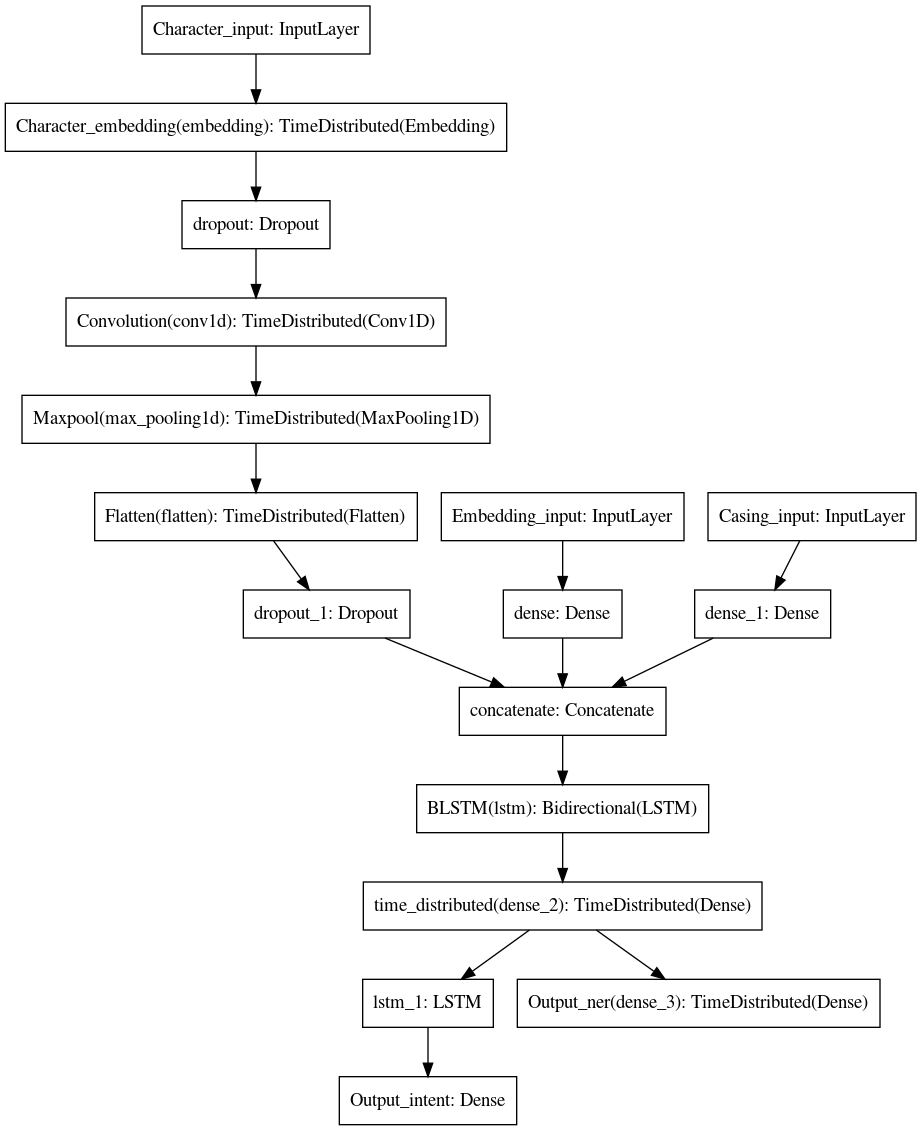

In [31]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

# Training

In [32]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

history = model.fit([train_embeddings_input, train_char_input, train_case_input], {"Output_ner": to_categorical(ner_train_output.reshape(-1,25,1), num_classes=len(label2idx)), "Output_intent": to_categorical(intent_train_output)}, batch_size=batch_size, epochs=epochs, validation_split=validation_split, verbose=1, callbacks=[es], use_multiprocessing=True)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 4480 samples, validate on 498 samples
Epoch 1/64
4480/4480 [==============================] - 31s 7ms/sample - loss: 1.5944 - Output_ner_loss: 0.4496 - Output_intent_loss: 1.1448 - Output_ner_acc: 0.9197 - Output_intent_acc: 0.7373 - val_loss: 1.0552 - val_Output_ner_loss: 0.1283 - val_Output_intent_loss: 0.9285 - val_Output_ner_acc: 0.9708 - val_Output_intent_acc: 0.7329
Epoch 2/64
4480/4480 [==============================] - 23s 5ms/sample - loss: 0.8410 - Output_ner_loss: 0.0989 - Output_intent_loss: 0.7421 - Output_ner_acc: 0.9753 - Output_intent_acc: 0.8078 - val_loss: 0.6020 - val_Output_ner_loss: 0.0752 - val_Output_intent_loss: 0.5394 - val_Output_ner_acc: 0.9822 - val_Output_intent_acc: 0.8815
Epoch 3/64
4480/4480 [==============================] - 23s 5ms/sample - loss: 0.5501 - Output_ner_loss: 0.0695 - Output_intent_loss: 0.4806 - Output_ner_acc: 0.9811 - Output_intent_acc

# Test part

In [33]:
test_char_input = np.asarray(transform_seq2char(test_data["token"], char2idx, max_sequence_length, max_char_length))
test_case_input = to_categorical(np.asarray(transform_seq2case(test_data["token"], case2idx, max_sequence_length)), num_classes=len(case2idx), dtype='float32')

if embedding_type == "bert":
    test_embeddings_input = client.encode(test_data["token"], is_tokenized=True)
elif embedding_type == "fasttext":
    test_embeddings_input = fasttext.texts_to_sequences(test_data["token"])
elif embedding_type == "glove":
    test_embeddings_input = glove.texts_to_sequences(test_data["token"], padding=max_sequence_length)
else:
    print("Unknown embedding_type: {}".format(embedding_type))

In [34]:
from sklearn.metrics import classification_report

y_pred_ner, y_pred_intent = model.predict([test_embeddings_input, test_char_input, test_case_input], batch_size=batch_size, verbose=1)


893/893 [==============================] - 2s 3ms/sample


In [35]:
ner_test_output = np.asarray([[label2idx[tag] for tag in example] for example in test_data["ner"]])
intent_test_output = np.asarray([intent2idx[x] for x in test_data["intent"]])

In [36]:
y_pred_intent_bool = np.argmax(y_pred_intent, axis=1)

In [37]:
intent_test_metric = classification_report(intent_test_output, y_pred_intent_bool, output_dict=True)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [38]:
intent_accuracy = sum([1 if x == y else 0 for x, y in zip(intent_test_output, y_pred_intent_bool)]) / float(len(intent_test_output))

In [39]:
intent_test_metric["weighted avg"]["f1-score"]

0.9533716122117921

In [40]:
y_pred_ner_bool = np.argmax(y_pred_ner, axis=2)

In [41]:
ner_pred_postprocessed = []
ner_test_postprocessed = []

for i, x in enumerate(ner_test_output):
    for item in y_pred_ner_bool[i][:len(x)]:
        ner_pred_postprocessed.append(item)
    for item in x[:len(y_pred_ner_bool[i][:len(x)])]:
        ner_test_postprocessed.append(item)

In [42]:
ner_test_metric = classification_report(ner_pred_postprocessed, ner_test_postprocessed, output_dict=True)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [43]:
ner_accuracy = sum([1 if x == y else 0 for x, y in zip(ner_pred_postprocessed, ner_test_postprocessed)]) / float(len(ner_pred_postprocessed))

In [44]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.savefig('val.png')
pyplot.show()

<Figure size 640x480 with 1 Axes>

In [45]:
import mlflow
import json

mlflow.set_tracking_uri("https://mlflow.XX.ai/")
mlflow.set_experiment("poster-2020-lorenc")

mlflow.log_param("embedding_type", embedding_type)

mlflow.log_param("max_sequence_length", max_sequence_length)
mlflow.log_param("max_char_length", max_char_length)
mlflow.log_param("embedding_dim", embedding_dim)
mlflow.log_param("dropout_rate", dropout_rate)
mlflow.log_param("recurrent_dropout_rate", recurrent_dropout_rate)
mlflow.log_param("lstm_size", lstm_size)
mlflow.log_param("dense_size_word", dense_size_word)
mlflow.log_param("dense_size_case", dense_size_case)

mlflow.log_param("batch_size", batch_size)
mlflow.log_param("epochs", epochs)
mlflow.log_param("validation_split", validation_split)

mlflow.log_param("optimizer", optimizer)
mlflow.log_param("n_labels", n_labels)
mlflow.log_param("n_chars", n_chars)
mlflow.log_param("n_intents", n_intents)

mlflow.log_metrics({str(k + "_ner"): v for k, v in ner_test_metric["weighted avg"].items()})
mlflow.log_metrics({str(k + "_intent"): v for k, v in intent_test_metric["weighted avg"].items()})
mlflow.log_metric("epochs_till_stop", len(history.history['loss']))
mlflow.log_metric("ner_accuracy", ner_accuracy)
mlflow.log_metric("intent_accuracy", intent_accuracy)

mlflow.log_artifact("./model.png")
mlflow.log_artifact("./val.png")

mlflow.end_run()